In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
from jax import random
from numpyro.infer import Predictive
from reusable.util import load_samples, gen_file_name, get_decoder_params, load_args, load_training_state
from reusable.gp import BuildGP
from reusable.mcmc import cvae_length_mcmc


In [2]:
args = load_args("15", "v6")
rng_key = random.PRNGKey(3)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Comparing GP to PriorVAE draws

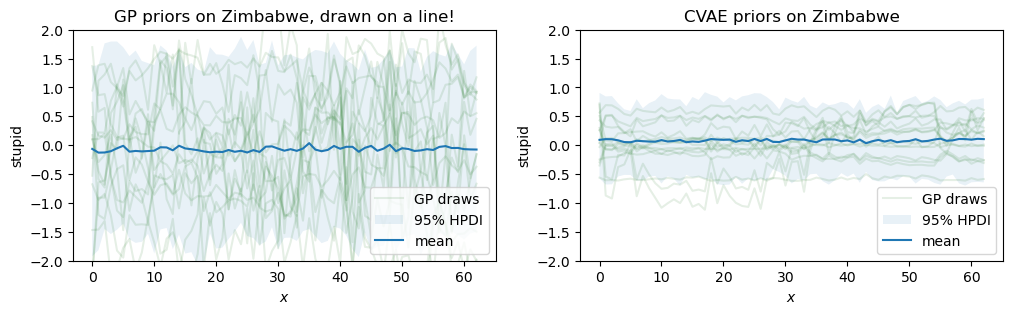

In [3]:
from plotting.plots import compare_draws
from reusable.vae import VAE
import optax
from reusable.train_nn import SimpleTrainState

rng_key, rng_key_init, rng_key_init_state, rng_key_plots = random.split(rng_key, 4)

to_plot = 200

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["x"].shape[0],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["x"].shape[0] + 1,)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
dummy_state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)


decoder_params = get_decoder_params(load_training_state("15", gen_file_name("15", args), dummy_state))


gp = BuildGP(args["gp_kernel"], 1e-5, args["length_prior_choice"], args["length_prior_arguments"])

cvae = cvae_length_mcmc(
    args["hidden_dim1"],
    args["hidden_dim2"],
    args["latent_dim"],
    decoder_params,
    args["length_prior_choice"],
    args["length_prior_arguments"],
)

gp_plot_pred = Predictive(gp, num_samples=to_plot)
gp_plot_samples = gp_plot_pred(rng_key_plots, x=args["x"], jitter=5e-5)

cvae_plot_pred = Predictive(cvae, num_samples=to_plot)
cvae_plot_samples = cvae_plot_pred(rng_key_plots, x=args["x"], jitter=5e-5)

compare_draws(
    jnp.arange(0, args["x"].shape[0]),
    gp_plot_samples["y"],
    cvae_plot_samples["f"],
    "GP priors on Zimbabwe, drawn on a line!",
    "CVAE priors on Zimbabwe",
    "stupid",
    "stupid",
)


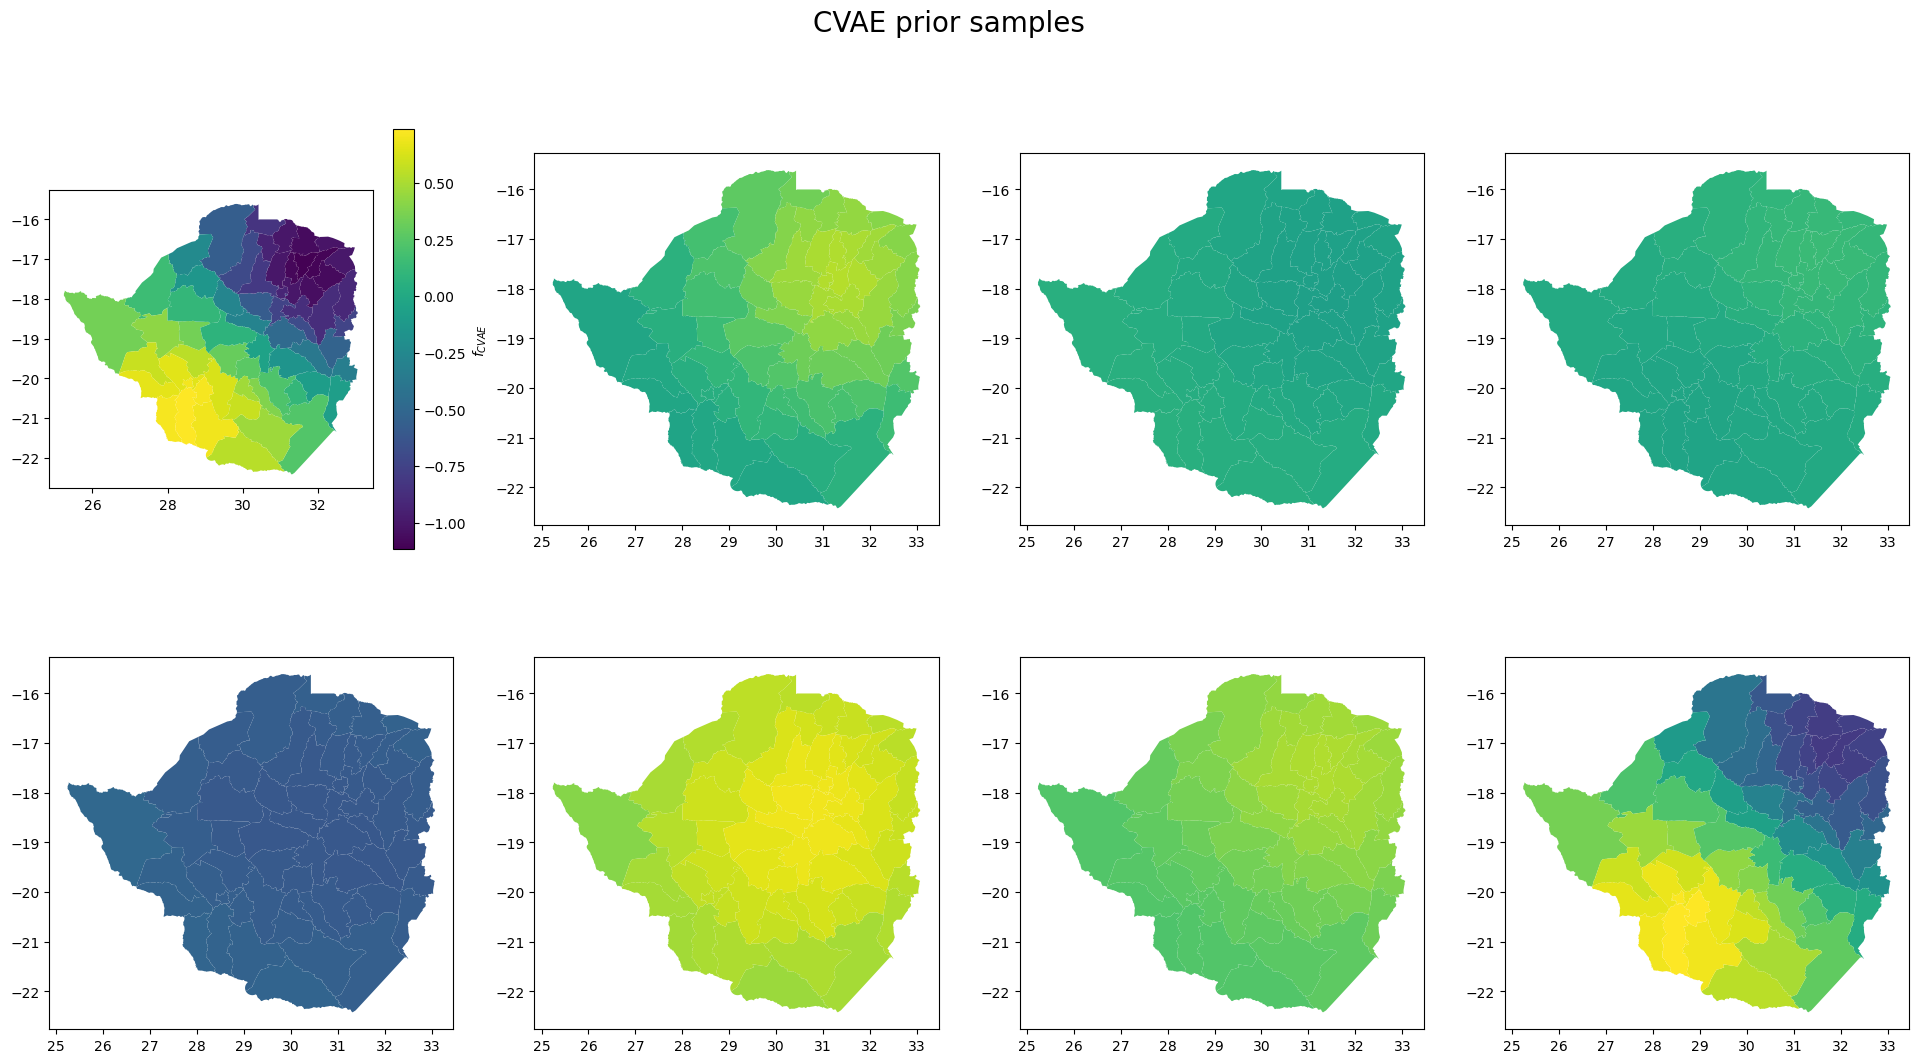

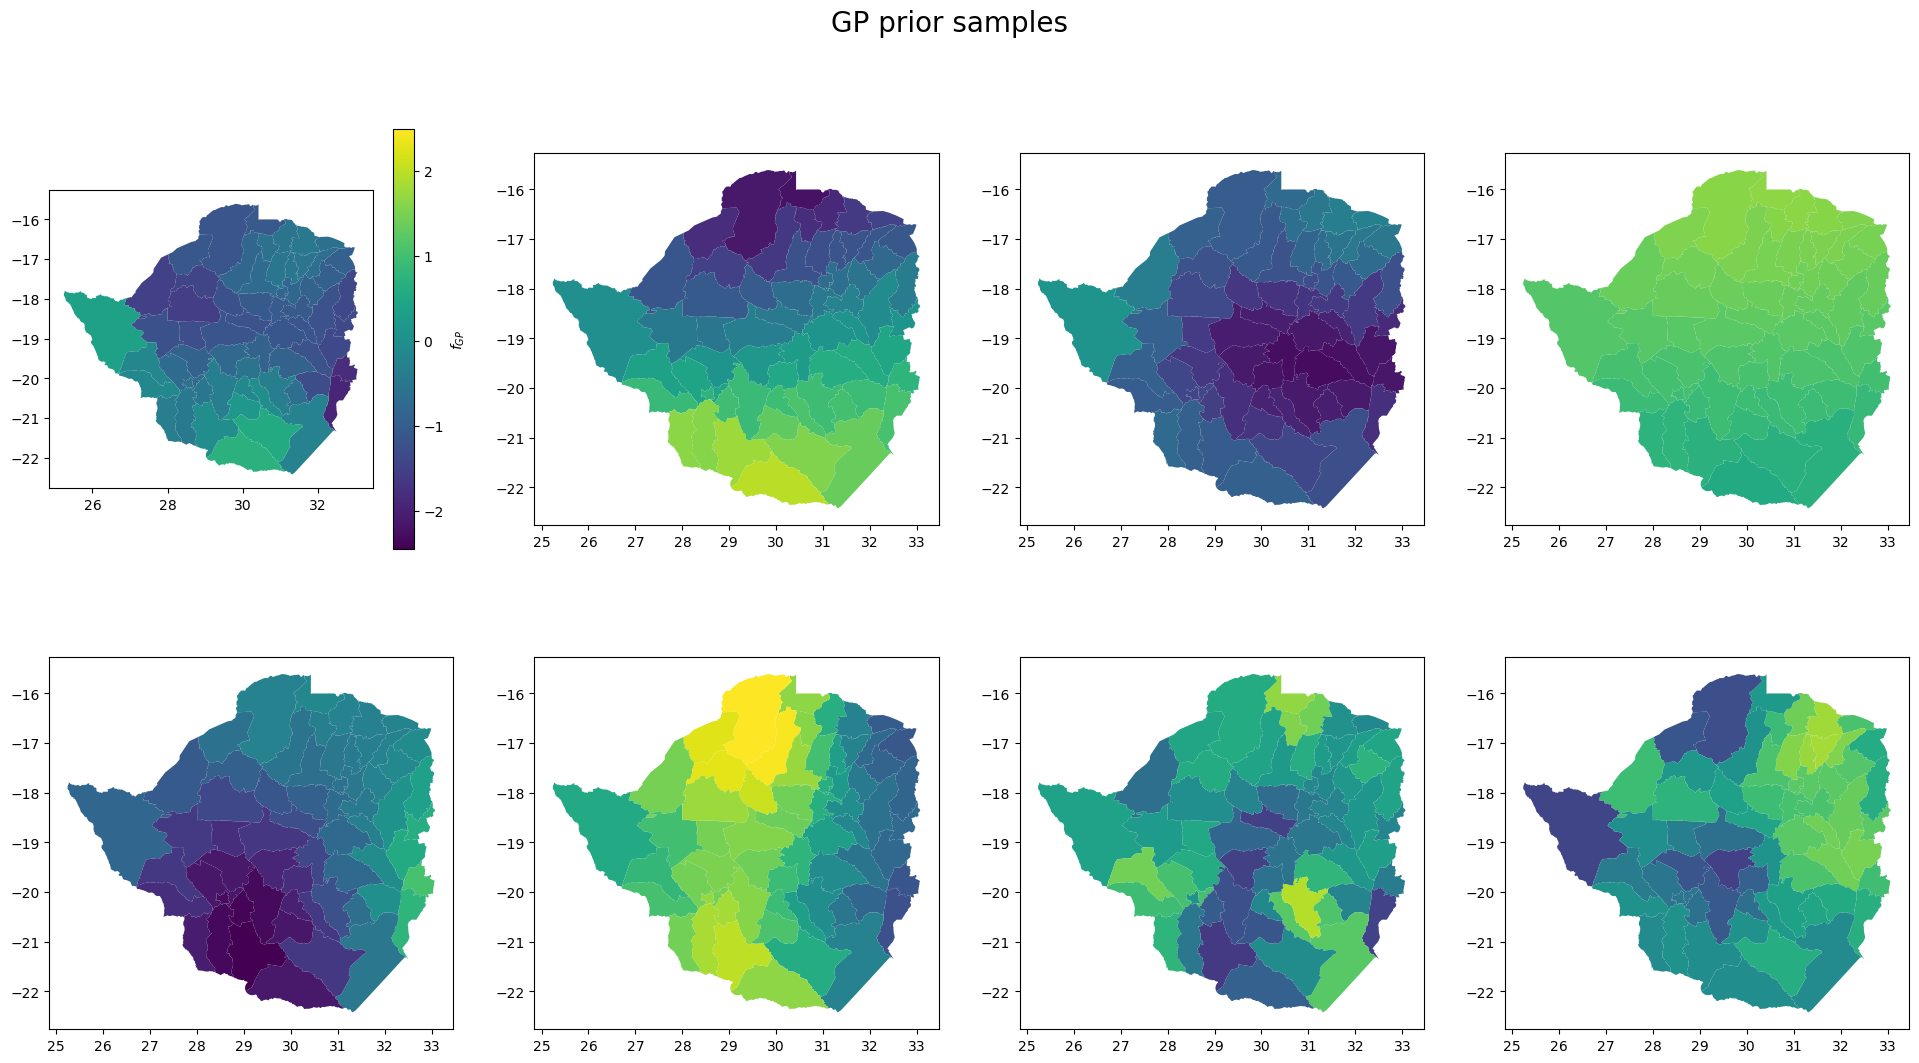

In [4]:
from plotting.zwe import plot_multi_on_zimbabwe

plot_multi_on_zimbabwe(cvae_plot_samples["f"][:8], "CVAE prior samples", "$f_{CVAE}$")

plot_multi_on_zimbabwe(gp_plot_samples["y"][:8], "GP prior samples", "$f_{GP}$")

### Ground truth

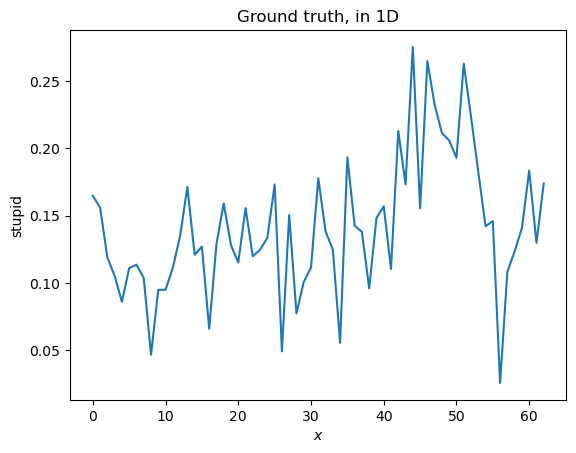

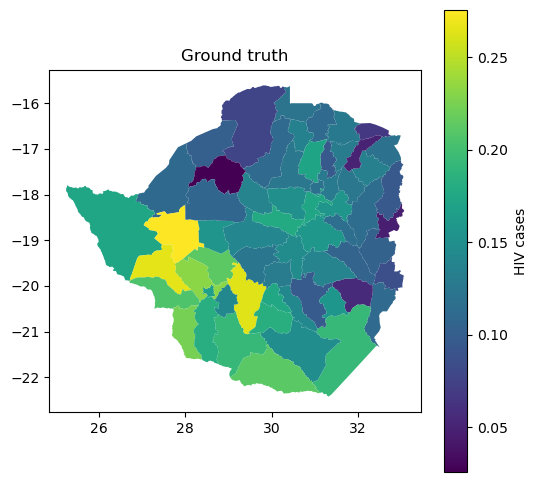

In [5]:
s = gpd.read_file("data/zwe2016phia.geojson")

ground_truth = jnp.array(s["estimate"])


from plotting.plots import plot_draws
from plotting.zwe import plot_on_zimbabwe

plot_draws(ground_truth[None], jnp.arange(args["x"].shape[0]), "Ground truth, in 1D", "stupid")

plot_on_zimbabwe(ground_truth, "Ground truth", "HIV cases")

### Inference with CVAE of lengthscale

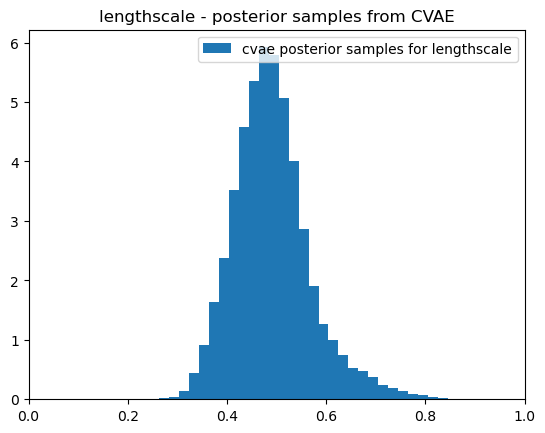

In [6]:
cvae_args = load_args("15", "v6")
cvae_args["num_chains"] = 3
cvae_mcmc_samples = load_samples("15", gen_file_name("15", cvae_args, "inference_cvae_mcmc", include_mcmc=True))


plt.hist(cvae_mcmc_samples["c"], density=True, label = 'cvae posterior samples for lengthscale', bins=40)
#plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('lengthscale - posterior samples from CVAE')
plt.legend()


### Inference with GP of lengthscale

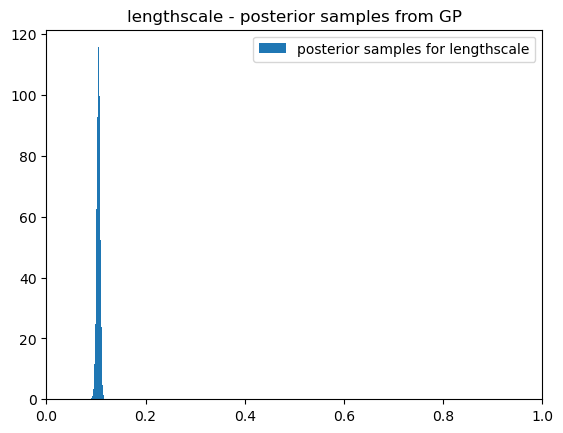

In [7]:
gp_args = load_args("15", "gp")

gp_mcmc_samples = load_samples("15", gen_file_name("15", gp_args, "inference_gp_mcmc", include_mcmc=True))

plt.hist(gp_mcmc_samples["kernel_length"], density=True, label = 'posterior samples for lengthscale', bins=40)
#plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('lengthscale - posterior samples from GP')
plt.legend()

### GP posterior predictive

(i.e. f before noise)

[0.43846667 0.38823205 0.42204157 ... 0.59407216 0.51531124 0.5377066 ]


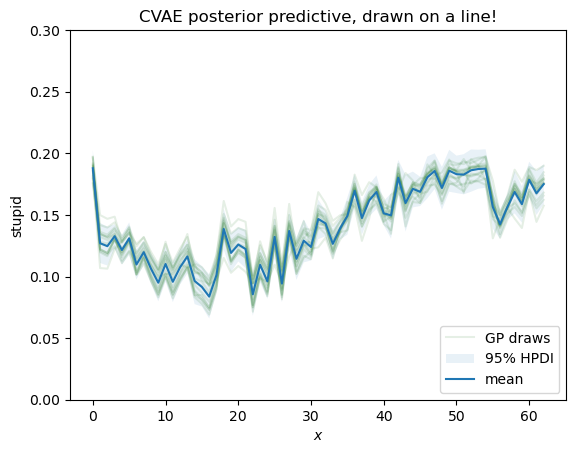

In [32]:
from plotting.plots import plot_draws_hpdi

rng_key, rng_key_pred = random.split(rng_key, 2)

s = {}
for key, val in cvae_mcmc_samples.items():
    s[key] = val[:100]

predictive = Predictive(cvae, cvae_mcmc_samples)
predictions = predictive(rng_key_pred, args["x"], y=ground_truth)

print()

plot_draws_hpdi(
    predictions["f"],
    jnp.arange(0, args["x"].shape[0]),
    "CVAE posterior predictive, drawn on a line!",
    "stupid",
    _min=0,
    _max=0.3
)



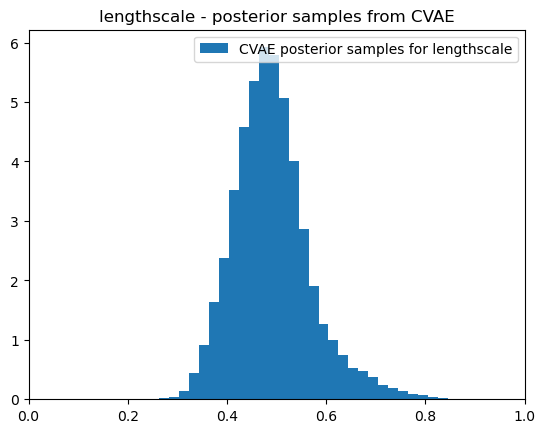

In [34]:


plt.hist(predictions["z_c"][:, -1], density=True, label = 'CVAE posterior samples for lengthscale', bins=40)
#plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('lengthscale - posterior samples from CVAE')
plt.legend()